# Recurrent Neural Networks

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

When working with sequential data (time-series, sentences, etc.) the order of the inputs is crucial for the task at hand. Recurrent neural networks (RNNs) process sequential data by accounting for the current input and also what has been learned from previous inputs. In this notebook, we'll learn how to create and train RNNs on sequential data.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/rnn.png" width=550>




# Overview

* **Objective:**  Process sequential data by accounting for the currend input and also what has been learned from previous inputs.
* **Advantages:** 
    * Account for order and previous inputs in a meaningful way.
    * Conditioned generation for generating sequences.
* **Disadvantages:** 
    * Each time step's prediction depends on the previous prediction so it's difficult to parallelize RNN operations. 
    * Processing long sequences can yield memory and computation issues.
    * Interpretability is difficult but there are few [techniques](https://arxiv.org/abs/1506.02078) that use the activations from RNNs to see what parts of the inputs are processed. 
* **Miscellaneous:** 
    * Architectural tweaks to make RNNs faster and interpretable is an ongoing area of research.

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/rnn2.png" width=650>

RNN forward pass for a single time step $X_t$:

$h_t = tanh(W_{hh}h_{t-1} + W_{xh}X_t+b_h)$

$y_t = W_{hy}h_t + b_y $

$ P(y) = softmax(y_t) = \frac{e^y}{\sum e^y} $

*where*:
* $X_t$ = input at time step t | $\in \mathbb{R}^{NXE}$ ($N$ is the batch size, $E$ is the embedding dim)
* $W_{hh}$ = hidden units weights| $\in \mathbb{R}^{HXH}$ ($H$ is the hidden dim)
* $h_{t-1}$ = previous timestep's hidden state $\in \mathbb{R}^{NXH}$
* $W_{xh}$ = input weights| $\in \mathbb{R}^{EXH}$
* $b_h$ = hidden units bias $\in \mathbb{R}^{HX1}$
* $W_{hy}$ = output weights| $\in \mathbb{R}^{HXC}$ ($C$ is the number of classes)
* $b_y$ = output bias $\in \mathbb{R}^{CX1}$

You repeat this for every time step's input ($X_{t+1}, X_{t+2}, ..., X_{N})$ to the get the predicted outputs at each time step.

**Note**: At the first time step, the previous hidden state $h_{t-1}$ can either be a zero vector (unconditioned) or initialize (conditioned). If we are conditioning the RNN, the first hidden state $h_0$ can belong to a specific condition or we can concat the specific condition to the randomly initialized hidden vectors at each time step. More on this in the subsequent notebooks on RNNs.

Let's see what the forward pass looks like with an RNN for a synthetic task such as processing reviews (a sequence of words) to predict the sentiment at the end of processing the review.

In [1]:
# Load PyTorch library
!pip3 install torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
batch_size = 5
seq_size = 10 # max length per input (masking will be used for sequences that aren't this max length)
x_lengths = [8, 5, 4, 10, 5] # lengths of each input sequence
embedding_dim = 100
rnn_hidden_dim = 256
output_dim = 4

In [4]:
# Initialize synthetic inputs
x_in = torch.randn(batch_size, seq_size, embedding_dim)
x_lengths = torch.tensor(x_lengths)
print (x_in.size())

torch.Size([5, 10, 100])


In [5]:
# Initialize hidden state
hidden_t = torch.zeros((batch_size, rnn_hidden_dim))
print (hidden_t.size())

torch.Size([5, 256])


In [6]:
# Initialize RNN cell
rnn_cell = nn.RNNCell(embedding_dim, rnn_hidden_dim)
print (rnn_cell)

RNNCell(100, 256)


In [7]:
# Forward pass through RNN
x_in = x_in.permute(1, 0, 2) # RNN needs batch_size to be at dim 1

# Loop through the inputs time steps
hiddens = []
for t in range(seq_size):
    hidden_t = rnn_cell(x_in[t], hidden_t)
    hiddens.append(hidden_t)
hiddens = torch.stack(hiddens)
hiddens = hiddens.permute(1, 0, 2) # bring batch_size back to dim 0
print (hiddens.size())

torch.Size([5, 10, 256])


In [8]:
# We also could've used a more abstracted layer
x_in = torch.randn(batch_size, seq_size, embedding_dim)
rnn = nn.RNN(embedding_dim, rnn_hidden_dim, batch_first=True)
out, h_n = rnn(x_in) #h_n is the last hidden state
print ("out: ", out.size())
print ("h_n: ", h_n.size())

out:  torch.Size([5, 10, 256])
h_n:  torch.Size([1, 5, 256])


In [ ]:
def gather_last_relevant_hidden(hiddens, x_lengths):
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

In [10]:
# Gather the last relevant hidden state
z = gather_last_relevant_hidden(hiddens, x_lengths)
print (z.size())

torch.Size([5, 256])


In [11]:
# Forward pass through FC layer
fc1 = nn.Linear(rnn_hidden_dim, output_dim)
y_pred = fc1(z)
y_pred = F.softmax(y_pred, dim=1)
print (y_pred.size())
print (y_pred)

torch.Size([5, 4])
tensor([[0.3030, 0.2351, 0.2168, 0.2452],
        [0.2614, 0.1912, 0.2617, 0.2858],
        [0.2428, 0.2600, 0.2254, 0.2717],
        [0.2379, 0.2226, 0.1901, 0.3494],
        [0.2629, 0.2854, 0.2146, 0.2371]], grad_fn=<SoftmaxBackward>)


# Sequential data

There are a variety of different sequential tasks that RNNs can help with.

1. **One to one**: there is one input and produces one output. 
    * Ex. Given a word predict it's class (verb, noun, etc.).
2. **One to many**: one input generates many outputs.
    * Ex. Given a sentiment (positive, negative, etc.) generate a review.
3. **Many to one**: Many inputs are sequentially processed to generate one output.
    * Ex. Process the words in a review to predict the sentiment.
4. **Many to many**: Many inputs are sequentially processed to generate many outputs.
    * Ex. Given a sentence in French, processes the entire sentence and then generate the English translation.
    * Ex. Given a sequence of time-series data, predict the probability of an event (risk of disease) at each time step.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/seq2seq.jpeg" width=700>

# Issues with vanilla RNNs

There are several issues with the vanilla RNN that we've seen so far. 

1. When we have an input sequence that has many time steps, it becomes difficult for the model to retain information seen earlier as we process more and more of the downstream timesteps. The goals of the model is to retain the useful components in the previously seen time steps but this becomes cumbersome when we have so many time steps to process. 

2. During backpropagation, the gradient from the loss has to travel all the way back towards the first time step. If our gradient is larger than 1 (${1.01}^{1000} = 20959$) or less than 1 (${0.99}^{1000} = 4.31e-5$) and we have lot's of time steps, this can quickly spiral out of control.

To address both these issues, the concept of gating was introduced to RNNs. Gating allows RNNs to control the information flow between each time step to optimize on the task. Selectively allowing information to pass through allows the model to process inputs with many time steps. The most common RNN gated varients are the long short term memory ([LSTM](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)) units and gated recurrent units ([GRUs](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)). You can read more about how these units work [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/gates.png" width=900>

In [ ]:
# GRU in PyTorch
gru = nn.GRU(input_size=embedding_dim, hidden_size=rnn_hidden_dim, 
             batch_first=True)

In [13]:
# Initialize synthetic input
x_in = torch.randn(batch_size, seq_size, embedding_dim)
print (x_in.size())

torch.Size([5, 10, 100])


In [14]:
# Forward pass
out, h_n = gru(x_in)
print ("out:", out.size())
print ("h_n:", h_n.size())

out: torch.Size([5, 10, 256])
h_n: torch.Size([1, 5, 256])


**Note**: Choosing whether to use GRU or LSTM really depends on the data and empirical performance. GRUs offer comparable performance with reduce number of parameters while LSTMs are more efficient and may make the difference in performance for your particular task.

# Bidirectional RNNs

There have been many advancements with RNNs ([attention](https://www.oreilly.com/ideas/interpretability-via-attentional-and-memory-based-interfaces-using-tensorflow), Quasi RNNs, etc.) that we will cover in later lessons but one of the basic and widely used ones are bidirectional RNNs (Bi-RNNs). The motivation behind bidirectional RNNs is to process an input sequence by both directions. Accounting for context from both sides can aid in performance when the entire input sequence is known at time of inference. A common application of Bi-RNNs is in translation where it's advantageous to look at an entire sentence from both sides when translating to another language (ie. Japanese → English).

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/birnn.png" width=700>

In [ ]:
# BiGRU in PyTorch
bi_gru = nn.GRU(input_size=embedding_dim, hidden_size=rnn_hidden_dim, 
                batch_first=True, bidirectional=True)

In [16]:
# Forward pass
out, h_n = bi_gru(x_in)
print ("out:", out.size()) # collection of all hidden states from the RNN for each time step
print ("h_n:", h_n.size()) # last hidden state from the RNN

out: torch.Size([5, 10, 512])
h_n: torch.Size([2, 5, 256])


Notice that the output for each sample at each timestamp has size 512 (double the hidden dim). This is because this includes both the forward and backward directions from the BiRNN. 

# Document classification with RNNs

Let's apply RNNs to the document classification task from the [emebddings notebook](https://colab.research.google.com/drive/1yDa5ZTqKVoLl-qRgH-N9xs3pdrDJ0Fb4) where we want to predict an article's category given its title.

## Set up

In [ ]:
import os
from argparse import Namespace
import collections
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [ ]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [22]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    data_file="news.csv",
    split_data_file="split_news.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="news",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    pretrained_embeddings=None,
    cutoff=25, # token must appear at least <cutoff> times to be in SequenceVocabulary
    num_epochs=5,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    embedding_dim=100,
    rnn_hidden_dim=128,
    hidden_dim=100,
    num_layers=1,
    bidirectional=False,
    dropout_p=0.1,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: True


## Data

In [ ]:
import re
import urllib

In [ ]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [25]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [26]:
# Split by category
by_category = collections.defaultdict(list)
for _, row in df.iterrows():
    by_category[row.category].append(row.to_dict())
for category in by_category:
    print ("{0}: {1}".format(category, len(by_category[category])))

Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


In [ ]:
# Create split data
final_list = []
for _, item_list in sorted(by_category.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [28]:
# df with split datasets
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    84000
val      18000
test     18000
Name: split, dtype: int64

In [ ]:
# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text
    
split_df.title = split_df.title.apply(preprocess_text)

In [30]:
# Save to CSV
split_df.to_csv(args.split_data_file, index=False)
split_df.head()

,category,split,title
0,Business,train,general electric posts higher rd quarter profit
1,Business,train,lilly to eliminate up to us jobs
2,Business,train,s amp p lowers america west outlook to negative
3,Business,train,does rand walk the talk on labor policy ?
4,Business,train,housekeeper advocates for changes


## Vocabulary

In [ ]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [38]:
# Vocabulary instance
category_vocab = Vocabulary()
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
index = category_vocab.lookup_token("Business")
print (index)
print (category_vocab.lookup_index(index))

<Vocabulary(size=4)>
4
0
Business


## Sequence vocabulary

Next, we're going to create our Vocabulary classes for the article's title, which is a sequence of tokens.

In [ ]:
from collections import Counter
import string

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)
        
        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'mask_token': self.mask_token,
                         'begin_seq_token': self.begin_seq_token,
                         'end_seq_token': self.end_seq_token})
        return contents

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)
    
    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the SequenceVocabulary" % index)
        return self.idx_to_token[index]
    
    def __str__(self):
        return "<SequenceVocabulary(size=%d)>" % len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)


In [41]:
# Get word counts
word_counts = Counter()
for title in split_df.title:
    for token in title.split(" "):
        if token not in string.punctuation:
            word_counts[token] += 1

# Create SequenceVocabulary instance
title_vocab = SequenceVocabulary()
for word, word_count in word_counts.items():
    if word_count >= args.cutoff:
        title_vocab.add_token(word)
print (title_vocab) # __str__
print (len(title_vocab)) # __len__
index = title_vocab.lookup_token("general")
print (index)
print (title_vocab.lookup_index(index))

<SequenceVocabulary(size=4400)>
4400
4
general


## Vectorizer

Something new that we introduce in this Vectorizer is calculating the length of our input sequence. We will use this later on to extract the last relevant hidden state for each input sequence.

In [ ]:
class NewsVectorizer(object):
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title):
        indices = [self.title_vocab.lookup_token(token) for token in title.split(" ")]
        indices = [self.title_vocab.begin_seq_index] + indices + \
            [self.title_vocab.end_seq_index]
        
        # Create vector
        title_length = len(indices)
        vector = np.zeros(title_length, dtype=np.int64)
        vector[:len(indices)] = indices

        return vector, title_length
    
    def unvectorize(self, vector):
        tokens = [self.title_vocab.lookup_index(index) for index in vector]
        title = " ".join(token for token in tokens)
        return title

    @classmethod
    def from_dataframe(cls, df, cutoff):
        
        # Create class vocab
        category_vocab = Vocabulary()        
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)

        # Get word counts
        word_counts = Counter()
        for title in df.title:
            for token in title.split(" "):
                word_counts[token] += 1
        
        # Create title vocab
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(title_vocab=title_vocab, category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [50]:
# Vectorizer instance
vectorizer = NewsVectorizer.from_dataframe(split_df, cutoff=args.cutoff)
print (vectorizer.title_vocab)
print (vectorizer.category_vocab)
vectorized_title, title_length = vectorizer.vectorize(preprocess_text(
    "Roger Federer wins the Wimbledon tennis tournament."))
print (np.shape(vectorized_title))
print ("title_length:", title_length)
print (vectorized_title)
print (vectorizer.unvectorize(vectorized_title))

<SequenceVocabulary(size=4404)>
<Vocabulary(size=4)>
(10,)
title_length: 10
[   2    1 4151 1231   25    1 2392 4076   38    3]
<BEGIN> <UNK> federer wins the <UNK> tennis tournament . <END>


## Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, split_data_file, cutoff):
        df = pd.read_csv(split_data_file, header=0)
        train_df = df[df.split=='train']
        return cls(df, NewsVectorizer.from_dataframe(train_df, cutoff))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, split_data_file, vectorizer_filepath):
        df = pd.read_csv(split_data_file, header=0)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NewsVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        title_vector, title_length = self.vectorizer.vectorize(row.title)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'title': title_vector, 'title_length': title_length, 
                'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, collate_fn, shuffle=True, 
                         drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size,
                                collate_fn=collate_fn, shuffle=shuffle, 
                                drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [55]:
# Dataset instance
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file,
                                                       args.cutoff)
print (dataset) # __str__
input_ = dataset[5] # __getitem__
print (input_['title'], input_['title_length'], input_['category'])
print (dataset.vectorizer.unvectorize(input_['title']))
print (dataset.class_weights)

<Dataset(split=train, size=84000)
[ 2 31 32 10 33 13  3] 7 0
<BEGIN> software firm to cut jobs <END>
tensor([3.3333e-05, 3.3333e-05, 3.3333e-05, 3.3333e-05])


## Model

input → embedding → RNN → FC 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def gather_last_relevant_hidden(hiddens, x_lengths):
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

In [ ]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, rnn_hidden_dim, 
                 hidden_dim, output_dim, num_layers, bidirectional, dropout_p, 
                 pretrained_embeddings=None, freeze_embeddings=False, 
                 padding_idx=0):
        super(NewsModel, self).__init__()
        
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                          num_embeddings=num_embeddings,
                                          padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=num_embeddings,
                                           padding_idx=padding_idx,
                                           _weight=pretrained_embeddings)
        
        # Conv weights
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=rnn_hidden_dim, 
                          num_layers=num_layers, batch_first=True, 
                          bidirectional=bidirectional)
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

    def forward(self, x_in, x_lengths, apply_softmax=False):
        
        # Embed
        x_in = self.embeddings(x_in)
            
        # Feed into RNN
        out, h_n = self.gru(x_in)
        
        # Gather the last relevant hidden state
        out = gather_last_relevant_hidden(out, x_lengths)

        # FC layers
        z = self.dropout(out)
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

## Training

In [ ]:
import torch.optim as optim

In [ ]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0:02d} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
    
    def pad_seq(self, seq, length):
        vector = np.zeros(length, dtype=np.int64)
        vector[:len(seq)] = seq
        vector[len(seq):] = self.dataset.vectorizer.title_vocab.mask_index
        return vector
    
    def collate_fn(self, batch):
        
        # Make a deep copy
        batch_copy = copy.deepcopy(batch)
        processed_batch = {"title": [], "title_length": [], "category": []}
        
        # Get max sequence length
        get_length = lambda sample: len(sample["title"])
        max_seq_length = max(map(get_length, batch))
        
        # Pad
        for i, sample in enumerate(batch_copy):
            padded_seq = self.pad_seq(sample["title"], max_seq_length)
            processed_batch["title"].append(padded_seq)
            processed_batch["title_length"].append(sample["title_length"])
            processed_batch["category"].append(sample["category"])
            
        # Convert to appropriate tensor types
        processed_batch["title"] = torch.LongTensor(
            processed_batch["title"])
        processed_batch["title_length"] = torch.LongTensor(
            processed_batch["title_length"])
        processed_batch["category"] = torch.LongTensor(
            processed_batch["category"])
        
        return processed_batch   
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['title'], batch_dict['title_length'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['title'], batch_dict['title_length'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, collate_fn=self.collate_fn, 
            shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['title'], batch_dict['title_length'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [88]:
# Initialization
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file,
                                                       args.cutoff)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  rnn_hidden_dim=args.rnn_hidden_dim,
                  hidden_dim=args.hidden_dim,
                  output_dim=len(vectorizer.category_vocab),
                  num_layers=args.num_layers,
                  bidirectional=args.bidirectional,
                  dropout_p=args.dropout_p, 
                  pretrained_embeddings=None, 
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3406, 100, padding_idx=0)
  (gru): GRU(100, 128, batch_first=True)
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [89]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 0.75 | [TRAIN ACC]: 70.7% | [VAL LOSS]: 0.54 | [VAL ACC]: 80.5%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 0.48 | [TRAIN ACC]: 82.7% | [VAL LOSS]: 0.49 | [VAL ACC]: 82.3%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 0.41 | [TRAIN ACC]: 85.0% | [VAL LOSS]: 0.47 | [VAL ACC]: 83.1%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 0.37 | [TRAIN ACC]: 86.6% | [VAL LOSS]: 0.47 | [VAL ACC]: 83.3%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 0.33 | [TRAIN ACC]: 88.2% | [VAL LOSS]: 0.49 | [VAL ACC]: 83.0%


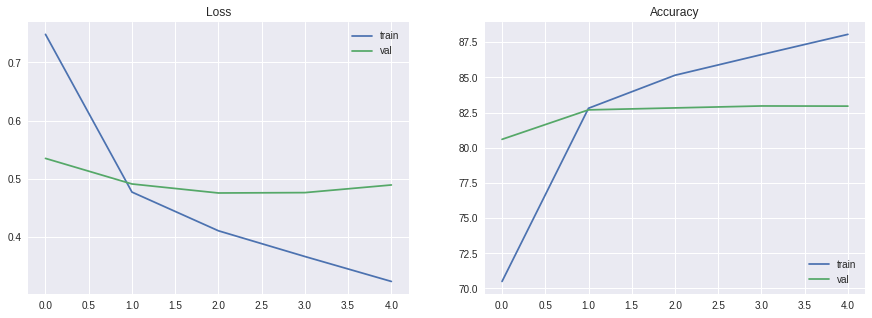

In [73]:
# Plot performance
trainer.plot_performance()

In [74]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.49
Test Accuracy: 82.9%


In [ ]:
# Save all results
trainer.save_train_state()

## Inference

In [ ]:
class Inference(object):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
  
    def predict_category(self, title):
        # Vectorize
        vectorized_title, title_length = self.vectorizer.vectorize(title)
        vectorized_title = torch.tensor(vectorized_title).unsqueeze(0)
        title_length = torch.tensor([title_length]).long()
        
        # Forward pass
        self.model.eval()
        y_pred = self.model(x_in=vectorized_title, x_lengths=title_length, 
                            apply_softmax=True)

        # Top category
        y_prob, indices = y_pred.max(dim=1)
        index = indices.item()

        # Predicted category
        category = vectorizer.category_vocab.lookup_index(index)
        probability = y_prob.item()
        return {'category': category, 'probability': probability}
    
    def predict_top_k(self, title, k):
        # Vectorize
        vectorized_title, title_length = self.vectorizer.vectorize(title)
        vectorized_title = torch.tensor(vectorized_title).unsqueeze(0)
        title_length = torch.tensor([title_length]).long()
        
        # Forward pass
        self.model.eval()
        y_pred = self.model(x_in=vectorized_title, x_lengths=title_length, 
                            apply_softmax=True)
        
        # Top k categories
        y_prob, indices = torch.topk(y_pred, k=k)
        probabilities = y_prob.detach().numpy()[0]
        indices = indices.detach().numpy()[0]

        # Results
        results = []
        for probability, index in zip(probabilities, indices):
            category = self.vectorizer.category_vocab.lookup_index(index)
            results.append({'category': category, 'probability': probability})

        return results

In [77]:
# Load the model
dataset = NewsDataset.load_dataset_and_load_vectorizer(
    args.split_data_file, args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  rnn_hidden_dim=args.rnn_hidden_dim,
                  hidden_dim=args.hidden_dim,
                  output_dim=len(vectorizer.category_vocab),
                  num_layers=args.num_layers,
                  bidirectional=args.bidirectional,
                  dropout_p=args.dropout_p, 
                  pretrained_embeddings=None, 
                  padding_idx=vectorizer.title_vocab.mask_index)
model.load_state_dict(torch.load(args.model_state_file))
model = model.to("cpu")
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3406, 100, padding_idx=0)
  (gru): GRU(100, 128, batch_first=True)
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [80]:
# Inference
inference = Inference(model=model, vectorizer=vectorizer)
title = input("Enter a title to classify: ")
prediction = inference.predict_category(preprocess_text(title))
print("{} → {} (p={:0.2f})".format(title, prediction['category'], 
                                   prediction['probability']))

Enter a title to classify: President Obama signed the petition during the White House dinner.
President Obama signed the petition during the White House dinner. → World (p=0.62)


In [82]:
# Top-k inference
top_k = inference.predict_top_k(preprocess_text(title), k=len(vectorizer.category_vocab))
print ("{}".format(title))
for result in top_k:
    print ("{} (p={:0.2f})".format(result['category'], 
                                   result['probability']))

President Obama signed the petition during the White House dinner.
World (p=0.62)
Sci/Tech (p=0.17)
Business (p=0.15)
Sports (p=0.06)


# Layer normalization

Recall from our [CNN notebook](https://colab.research.google.com/github/GokuMohandas/practicalAI/blob/master/notebooks/11_Convolutional_Neural_Networks.ipynb) that we used batch normalization to deal with internal covariant shift. Our activations will experience the same issues with RNNs but we will use a technique known as [layer normalization](https://arxiv.org/abs/1607.06450) (layernorm) to maintain zero mean unit variance on the activations. 

With layernorm it's a bit different from batchnorm. We compute the mean and var for every single sample (instead of each hidden dim) for each layer independently and then do the operations on the activations before they go through the nonlinearities. PyTorch's [LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) class abstracts all of this for us when we feed in inputs to the layer.

$ LN = \frac{a - \mu_{L}}{\sqrt{\sigma^2_{L} + \epsilon}}  * \gamma + \beta $

where:
* $a$ = activation | $\in \mathbb{R}^{NXH}$ ($N$ is the number of samples, $H$ is the hidden dim)
* $ \mu_{L}$ = mean of input| $\in \mathbb{R}^{NX1}$
* $\sigma^2_{L}$ = variance of input | $\in \mathbb{R}^{NX1}$
* $epsilon$ = noise
* $\gamma$ = scale parameter (learned parameter)
* $\beta$ = shift parameter (learned parameter)

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/layernorm.png" width=400>

The most useful location to apply layernorm will be inside the RNN on the activations before the non-linearities. However, this is a bit involved and though PyTorch has a [LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) class, they do not have an RNN that has built in layernorm yet. You could implement the RNN yourself and manually add layernorm by following a similar setup like below.

```python
# Layernorm
for t in range(seq_size):
    # Normalize over hidden dim
    layernorm = nn.LayerNorm(args.hidden_dim)
    # Activating the module
    a = layernorm(x)
```

# TODO

- interpretability with task to see which words were most influential